# Importing Libraries

In [1]:
# %pip install pandas numpy seaborn matplotlib scikit-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier 


import pickle as pkl
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# import hyperopt
import shutil
import os

from models import decision_tree, k_nearest, logistic_regression, random_forest, support_vector_cls, xgboost

# Importing Data

In [18]:
# Read the file names in the Data Folder using os and put into a dictionary with key as index and value as filename
# csv_file_names = {i: file.split('.')[0] for i, file in enumerate(os.listdir('Data'))}
csv_file_names = {0: 'DUKE_384_531',
                1: 'DUKE_922_531',
                2: 'IIITD_384_109',
                3: 'IIITD_384_109_OTSU',
                4: 'IIITD_922_109',
                5: 'IIITD_922_109_OTSU',
                6: 'MAX_384_112',
                7: 'MAX_384_856'}

CRITERION = 'f1'

FILE_INDEX = 1
FILENAME = os.path.join('Data', csv_file_names[FILE_INDEX]+'.csv')
CLASS_LABELS = '../../Data/Patient class labels.csv'

# Create assertion error to check if the df shape from the filename and actual df shape are same
# print(list(pd.read_csv(FILENAME).shape), [int(i) for i in csv_file_names[FILE_INDEX].split('_')[1:3]])
assert list(pd.read_csv(FILENAME).shape) == [int(i) for i in csv_file_names[FILE_INDEX].split('_')[1:3]], "Shape of the dataframe is not same as the shape mentioned in the filename"


if not os.path.exists('Results'):
    os.makedirs('Results')

# STRATIFICATION_SPLIT = 'HER2'
RESULTS = os.path.join('Results', csv_file_names[FILE_INDEX])
FINAL_METRICS = os.path.join(RESULTS, 'Final_Metrics')
TRAINED_MODELS = os.path.join(RESULTS, 'Trained_Models')
BEST_MODELS = os.path.join(TRAINED_MODELS, 'Best_Models')
TEST_DF = os.path.join('Test Data', csv_file_names[FILE_INDEX]+f'_test.csv')

if not os.path.exists('Test Data'):
    os.makedirs('Test Data')


# function to check and create directories
def check_and_create_dir(directory):
    if os.path.exists(directory):
        print("Deleting existing directory: ", directory)
        shutil.rmtree(directory)
    os.makedirs(directory)


check_and_create_dir(RESULTS)
check_and_create_dir(FINAL_METRICS)
check_and_create_dir(TRAINED_MODELS)
check_and_create_dir(BEST_MODELS)


randgen = 12345678
train_size = 0.7
test_size = 0.18
val_size = 0.12

Deleting existing directory:  Results\DUKE_922_531


In [4]:
df = pd.read_csv(FILENAME).drop(columns = 'sequence', errors='ignore')
labels = pd.read_csv(CLASS_LABELS)
total_features = pd.merge(df, labels, left_on = 'PatientID', right_on = 'Patient ID').drop(columns = ['PatientID', 'Patient ID'])
total_features

,"F1_DT_POSTCON (T11=0.05,T12=0.5)","F1_DT_POSTCON (T11=0.05,T12=0.1)","F1_DT_POSTCON (T11=0.02,T12=0.5)","F1_DT_POSTCON (T11=0.02,T12=0.8)","F1_DT_POSTCON (T11=0.05,T12=0.8)","F1_DT_POSTCON (T11=0.1,T12=0.5)","F1_DT_POSTCON (T11=0.1,T12=0.8)","F1_DT_POSTCON (T11=0.2,T12=0.5)","F1_DT_POSTCON (T11=0.2,T12=0.8)","F1_DT_T1NFS (T11=0.05,T12=0.5)",...,WashinRate_map_inverse_difference_normalized_tissue_PostCon,WashinRate_map_inverse_difference_moment_normalized_tissue_PostCon,WashinRate_map_mean_tissue_PostCon,WashinRate_map_std_dev_tissue_PostCon,WashinRate_map_skewness_tissue_PostCon,WashinRate_map_kurtosis_tissue_PostCon,ER,PR,HER2,Mol Subtype
0,1.000000,0.120721,0.530395,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.960359,0.996829,14.517894,20.347506,1.625870,11.406955,0,0,1,2
1,1.000000,0.129546,0.485217,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.432916,...,0.959067,0.996363,47.297950,83.909561,0.251498,5.659428,0,0,0,3
2,0.174775,0.062051,0.069910,0.132265,0.330662,0.349550,0.661324,0.699100,1.00000,0.185670,...,0.957527,0.995981,114.171582,129.252343,1.928743,11.554948,1,1,0,0
3,0.086546,0.045111,0.034619,0.051265,0.128162,0.173093,0.256325,0.346185,0.51265,0.147088,...,0.960705,0.996827,33.499175,69.164227,1.171314,8.493319,1,1,0,0
4,0.289669,0.052031,0.115868,0.378575,0.839984,0.579338,1.000000,0.958287,1.00000,0.392859,...,0.930624,0.989135,34.406635,26.951415,0.985464,4.331451,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.587345,0.115746,0.234938,0.479802,1.000000,1.000000,1.000000,1.000000,1.00000,0.336273,...,0.970250,0.997982,30.665570,65.018278,1.563114,12.928674,1,1,0,0
918,0.122467,0.047881,0.048987,0.080580,0.201450,0.244934,0.402899,0.489868,1.00000,0.143506,...,0.953593,0.995567,19.556209,23.267576,0.463802,4.820925,1,1,0,0
919,0.742209,0.058729,0.296884,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.609958,...,0.961318,0.996820,17.724748,18.299932,2.282520,13.460166,1,1,0,0
920,0.381016,0.089668,0.152406,0.256513,0.641281,0.768252,1.000000,1.000000,1.00000,0.313589,...,0.968191,0.997618,149.643082,157.235282,1.318530,9.176372,1,1,0,0


In [5]:
# Remove the rows containing NaN values
total_features = total_features.dropna()
total_features

,"F1_DT_POSTCON (T11=0.05,T12=0.5)","F1_DT_POSTCON (T11=0.05,T12=0.1)","F1_DT_POSTCON (T11=0.02,T12=0.5)","F1_DT_POSTCON (T11=0.02,T12=0.8)","F1_DT_POSTCON (T11=0.05,T12=0.8)","F1_DT_POSTCON (T11=0.1,T12=0.5)","F1_DT_POSTCON (T11=0.1,T12=0.8)","F1_DT_POSTCON (T11=0.2,T12=0.5)","F1_DT_POSTCON (T11=0.2,T12=0.8)","F1_DT_T1NFS (T11=0.05,T12=0.5)",...,WashinRate_map_inverse_difference_normalized_tissue_PostCon,WashinRate_map_inverse_difference_moment_normalized_tissue_PostCon,WashinRate_map_mean_tissue_PostCon,WashinRate_map_std_dev_tissue_PostCon,WashinRate_map_skewness_tissue_PostCon,WashinRate_map_kurtosis_tissue_PostCon,ER,PR,HER2,Mol Subtype
0,1.000000,0.120721,0.530395,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.960359,0.996829,14.517894,20.347506,1.625870,11.406955,0,0,1,2
1,1.000000,0.129546,0.485217,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.432916,...,0.959067,0.996363,47.297950,83.909561,0.251498,5.659428,0,0,0,3
2,0.174775,0.062051,0.069910,0.132265,0.330662,0.349550,0.661324,0.699100,1.00000,0.185670,...,0.957527,0.995981,114.171582,129.252343,1.928743,11.554948,1,1,0,0
4,0.289669,0.052031,0.115868,0.378575,0.839984,0.579338,1.000000,0.958287,1.00000,0.392859,...,0.930624,0.989135,34.406635,26.951415,0.985464,4.331451,1,0,1,1
5,0.297156,0.074791,0.118862,0.253568,0.633921,0.594311,1.000000,1.000000,1.00000,0.445015,...,0.954940,0.995613,277.427199,252.568247,1.014581,5.344516,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,0.091844,0.050240,0.036738,0.103783,0.259457,0.183688,0.518915,0.367377,0.90289,0.125807,...,0.935277,0.989856,591.035965,397.002913,0.449477,2.857014,0,0,0,3
917,0.587345,0.115746,0.234938,0.479802,1.000000,1.000000,1.000000,1.000000,1.00000,0.336273,...,0.970250,0.997982,30.665570,65.018278,1.563114,12.928674,1,1,0,0
919,0.742209,0.058729,0.296884,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.609958,...,0.961318,0.996820,17.724748,18.299932,2.282520,13.460166,1,1,0,0
920,0.381016,0.089668,0.152406,0.256513,0.641281,0.768252,1.000000,1.000000,1.00000,0.313589,...,0.968191,0.997618,149.643082,157.235282,1.318530,9.176372,1,1,0,0


In [6]:
def train_test_val_split(df, train_ratio, val_ratio, random_state = 2454259):
    val_ratio_adj = val_ratio / (1-train_ratio)
    # stratification = df[stratify_class_name]
    train_df, val_df = train_test_split(df, train_size = train_ratio, random_state= random_state)
    # stratification = val_df[stratify_class_name]
    val_df, test_df = train_test_split(val_df, train_size = val_ratio_adj, random_state= random_state)

    return train_df, val_df, test_df

In [7]:
train_df, val_df, test_df = train_test_val_split(total_features, train_size, val_size)

In [8]:
# Save test_df to csv file
test_df.to_csv(TEST_DF, index = False)

In [9]:
# Defining a mask dataset
def mask_dataset(df, mask):
    '''Function to prepare the dataset based on the mask. For. eg: if mask is 'er_pr', then dataset will have PR as y and the remaining features as X'''
    mask = mask.upper()
    classes = mask.strip('_').split('_')
    y_class = classes[-1]
    classes = classes[:-1]
    subtypes = ['ER', 'PR', 'HER2', 'Mol Subtype']
    y = df[y_class]
    x = df.copy()
    for subtype in subtypes:
        # Dropping the labels not required
        if subtype not in classes:
            x = x.drop(columns = subtype)
    return x, y

## Data Information

In [10]:
# splitting the dataset for training, testing, validating on ER subtype
train_x_er, train_y_er = train_df.drop(columns = ['ER']), train_df['ER']
val_x_er, val_y_er = val_df.drop(columns = ['ER']), val_df['ER']
test_x_er, test_y_er = test_df.drop(columns = ['ER']), test_df['ER']

# splitting the dataset for training, testing, validating on PR subtyp
train_x_pr, train_y_pr = train_df.drop(columns = ['PR']), train_df['PR']
val_x_pr, val_y_pr = val_df.drop(columns = ['PR']), val_df['PR']
test_x_pr, test_y_pr = test_df.drop(columns = ['PR']), test_df['PR']

# splitting the dataset for training, testing, validating on HER2 subtype
train_x_her2, train_y_her2 = train_df.drop(columns = ['HER2']), train_df['HER2']
val_x_her2, val_y_her2 = val_df.drop(columns = ['HER2']), val_df['HER2']
test_x_her2, test_y_her2 = test_df.drop(columns = ['HER2']), test_df['HER2']

# splitting the dataset for training, testing, validating on molecular subtype
train_x_mol_subtype, train_y_mol_subtype = train_df.drop(columns = ['Mol Subtype']), train_df['Mol Subtype']
val_x_mol_subtype, val_y_mol_subtype = val_df.drop(columns = ['Mol Subtype']), val_df['Mol Subtype']
test_x_mol_subtype, test_y_mol_subtype = test_df.drop(columns = ['Mol Subtype']), test_df['Mol Subtype']

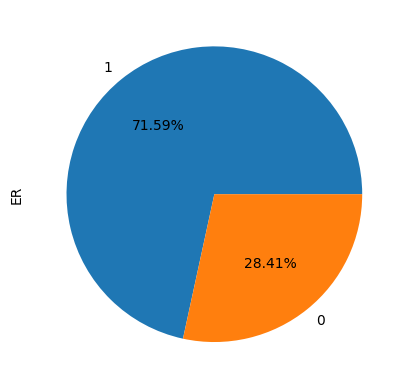

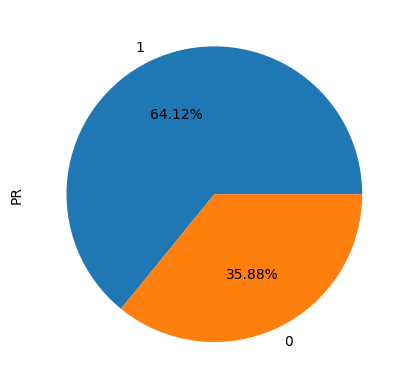

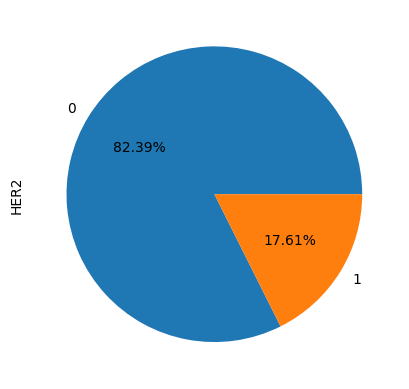

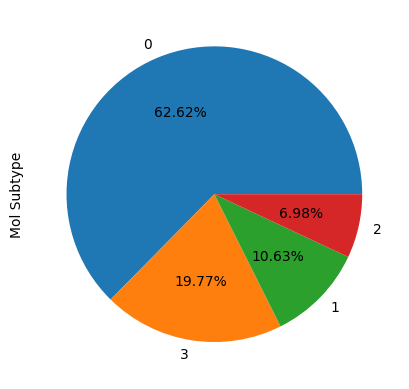

In [11]:
train_df['ER'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['PR'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['HER2'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['Mol Subtype'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [12]:
print("Train:", len(train_x_er), ", Val:", len(val_x_er), ", Test:", len(test_x_er))
dist = pd.DataFrame({'ER+': [train_y_er.value_counts()[0], val_y_er.value_counts()[0], test_y_er.value_counts()[0]],
                     'ER-': [train_y_er.value_counts()[1], val_y_er.value_counts()[1], test_y_er.value_counts()[1]],
                     'PR+': [train_y_pr.value_counts()[0], val_y_pr.value_counts()[0], test_y_pr.value_counts()[0]],
                     'PR-': [train_y_pr.value_counts()[1], val_y_pr.value_counts()[1], test_y_pr.value_counts()[1]],
                     'HER2+': [train_y_her2.value_counts()[0], val_y_her2.value_counts()[0], test_y_her2.value_counts()[0]],
                     'HER2-': [train_y_her2.value_counts()[1], val_y_her2.value_counts()[1], test_y_her2.value_counts()[1]],
                     'Mol Subtype (0)': [train_y_mol_subtype.value_counts()[0], val_y_mol_subtype.value_counts()[0], test_y_mol_subtype.value_counts()[0]],
                     'Mol Subtype (1)': [train_y_mol_subtype.value_counts()[1], val_y_mol_subtype.value_counts()[1], test_y_mol_subtype.value_counts()[1]],
                     'Mol Subtype (2)': [train_y_mol_subtype.value_counts()[2], val_y_mol_subtype.value_counts()[2], test_y_mol_subtype.value_counts()[2]],
                     'Mol Subtype (3)': [train_y_mol_subtype.value_counts()[3], val_y_mol_subtype.value_counts()[3], test_y_mol_subtype.value_counts()[3]]},
                     index = ['Train', 'Val', 'Test'])
dist

Train: 602 , Val: 103 , Test: 156


,ER+,ER-,PR+,PR-,HER2+,HER2-,Mol Subtype (0),Mol Subtype (1),Mol Subtype (2),Mol Subtype (3)
Train,171,431,216,386,496,106,377,64,42,119
Val,30,73,44,59,78,25,61,14,11,17
Test,28,128,53,103,129,27,107,22,5,22


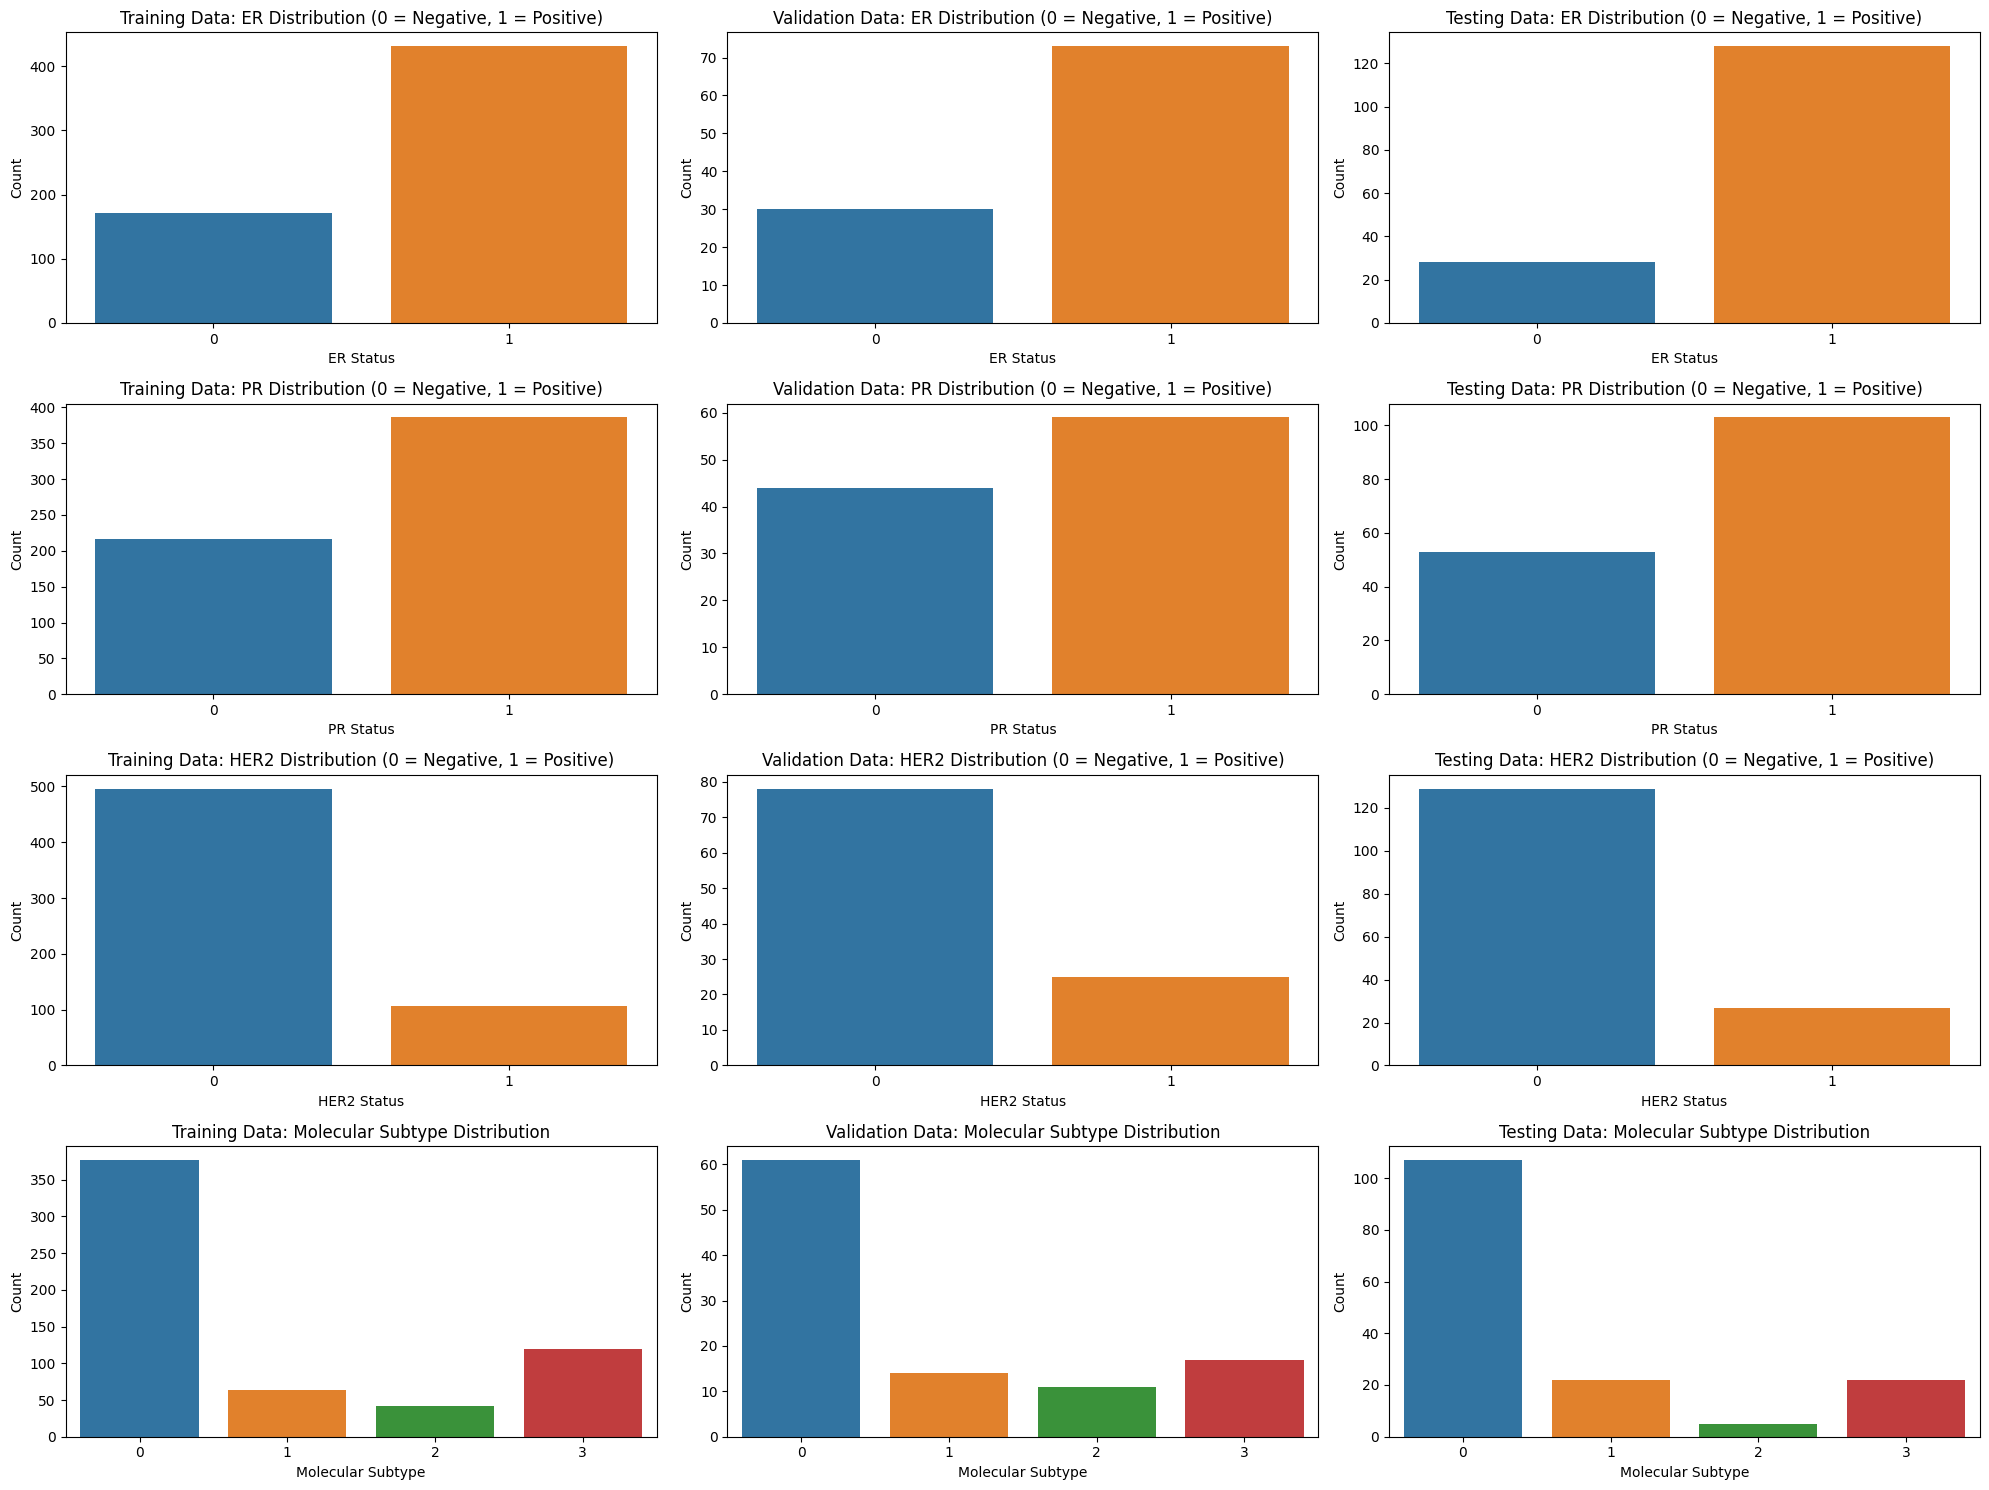

In [13]:
# creating multiple subplots of graph to visualise the above data 
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
plot_data = [[train_y_er, val_y_er, test_y_er], [train_y_pr, val_y_pr, test_y_pr], [train_y_her2, val_y_her2, test_y_her2], [train_y_mol_subtype, val_y_mol_subtype, test_y_mol_subtype]]
for i in range(4):
    for j in range(3):
        sns.countplot(x=plot_data[i][j], ax=axes[i][j])
        if i == 0:
            axes[i][j].set_xlabel('ER Status')
            if j == 0:
                axes[i][j].set_title('Training Data: ER Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: ER Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: ER Distribution (0 = Negative, 1 = Positive)')
        
        elif i == 1:
            axes[i][j].set_xlabel('PR Status')
            if j == 0:
                axes[i][j].set_title('Training Data: PR Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: PR Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: PR Distribution (0 = Negative, 1 = Positive)')
        
        elif i == 2:
            axes[i][j].set_xlabel('HER2 Status')
            if j == 0:
                axes[i][j].set_title('Training Data: HER2 Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: HER2 Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: HER2 Distribution (0 = Negative, 1 = Positive)')
        
        else:
            axes[i][j].set_xlabel('Molecular Subtype')
            if j == 0:
                axes[i][j].set_title('Training Data: Molecular Subtype Distribution')
            elif j == 1:
                axes[i][j].set_title('Validation Data: Molecular Subtype Distribution')
            else:
                axes[i][j].set_title('Testing Data: Molecular Subtype Distribution')

        axes[i][j].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Models

In [14]:
def get_metrics(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}

In [15]:
def get_NB_model(tx, ty, vx, vy, testx, testy, classification = None):
    nb = GaussianNB()
    nb.fit(tx, ty)
    
    train_metrics = get_metrics(nb, tx, ty, 'train')
    val_metrics = get_metrics(nb, vx, vy, 'val')
    test_metrics = get_metrics(nb, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Naive Bayes'
    if classification is not None:
        result['classification'] = classification

    return result, nb

def get_DT_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Decision Tree model with metrics'''
    model = decision_tree.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Decision Tree'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get KNN model with metrics'''
    model = k_nearest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'KNN'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_LR_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Logistic Regression model with metrics'''
    model = logistic_regression.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Logistic Regression'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_RF_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Random forest model with metrics'''
    model = random_forest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Random Forest'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get SVM model with metrics'''
    model = support_vector_cls.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'SVM'
    if classification is not None:
        result['classification'] = classification

    return result, model
    
def get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get XGBoost model with metrics'''
    model = xgboost.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **train_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'XGBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

# Integrated Pipeline for ML Models

In [16]:
def train_pipeline(train_df, val_df, test_df, pipeline_type, random_state = 2454259):
    '''Function to train the model based on the model type. Model type is a string with the subtypes seperated by '_'. For eg: 'ER_PR_HER2' '''
    pipeline_order = pipeline_type.split('_')
    model_type = ''
    # model_type = 'ER_PR'
    # pipeline_order = ['HER2']
    classification_results = pd.DataFrame()
    models = {}
    print('#'*50)
    print(f'Training the integrated Pipeline {pipeline_type}...')
    # splits = {}
    best_models = {}
    for sub_type in pipeline_order:
        print('-'*50)
        # if sub_type != 'HER2':
        #     print('Skipping others')
        #     print('-'*50)
        #     continue
        model_type = model_type +'_'+ sub_type + '_'
        model_type = model_type.strip('_')
        tx, ty = mask_dataset(train_df, model_type)
        vx, vy = mask_dataset(val_df, model_type)
        testx, testy = mask_dataset(test_df, model_type)
        # splits[model_type] = [tx, ty, vx, vy, testx, testy]

        print('Splitting for: ', model_type)
        
        # print('Before Scaling: ')
        # print(tx)
        # print(vx)
        # Applying Feature Scaling to the data using the Standard Scaler
        scaler = StandardScaler()
        tx = scaler.fit_transform(tx)
        vx = scaler.transform(vx)
        testx = scaler.transform(testx)

        # Converting to dataframe
        tx = pd.DataFrame(tx)
        vx = pd.DataFrame(vx)
        testx = pd.DataFrame(testx)

        # Checking the unique values in tx and vx last 3 columns
        # print('After Scaling: ')
        # print(tx)
        # print(vx)

        # Applying Principal Component Analysis to the data

        # pca = PCA(n_components = 'mle', svd_solver = 'full')
        # if no of features is more than no of samples then use arpack else use mle
        # print(tx.shape[1], tx.shape[0])
        if tx.shape[1] <= tx.shape[0]:
            pca = PCA(n_components = 'mle', svd_solver ='full')
        else:
            pca = PCA(svd_solver ='arpack')
        tx = pca.fit_transform(tx)
        vx = pca.transform(vx)
        testx = pca.transform(testx)
        
        print('Training Model: ', model_type)

        print('Running Naive Bayes...')
        res_nb, nb = get_NB_model(tx, ty, vx, vy, testx, testy, classification = model_type)
        print('Running Decision Trees...')
        res_dt, dt = get_DT_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)
        print('Running KNN...')
        res_knn, knn = get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)
        print('Running Logistic Regression...')
        res_lr, lr = get_LR_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)
        print('Running Random Forest...')
        res_rf, rf = get_RF_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)
        print('Running SVM...')
        res_svm, svm = get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)
        # print('Running XGBoost...')
        # res_xgb, xgb = get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = model_type)

        models[model_type] = {'Naive Bayes' : Pipeline([('scaler', scaler), ('pca', pca), ('nb', nb)]),
                              'Decision Tree' : Pipeline([('scaler', scaler), ('pca', pca), ('dt', dt)]),
                              'KNN' : Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)]),
                              'Logistic Regression' : Pipeline([('scaler', scaler), ('pca', pca), ('lr', lr)]),
                              'Random Forest' : Pipeline([('scaler', scaler), ('pca', pca), ('rf', rf)]),
                              'SVM' : Pipeline([('scaler', scaler), ('pca', pca), ('svm', svm)]),
                              # 'XGBoost' : Pipeline([('scaler', scaler), ('pca', pca), ('xgb', xgb)])
                              }

        classification_results = pd.concat([classification_results,
                                            res_nb,
                                            res_dt,
                                            res_knn,
                                            res_lr,
                                            res_rf,
                                            res_svm])
        
        # Getting the best model based on the CRIETERION
        best_model = classification_results[classification_results['classification'] == model_type].sort_values(by = f'test_{CRITERION}', ascending = False).iloc[0]
        best_model_name = best_model['Algorithm']
        best_models[model_type] = {'model' : models[model_type][best_model_name],
                                   'name': best_model_name,
                                    'classification' : sub_type,
                                    'strength' : best_model[f'val_{CRITERION}']}
        print(f'Best Model: {best_model_name} ({best_model[f"val_{CRITERION}"]})')

    return classification_results, models, best_models

In [17]:
pipelines = ['ER_PR_HER2', 'PR_ER_HER2', 'HER2_ER_PR', 'HER2_PR_ER', 'PR_HER2_ER', 'ER_HER2_PR']
# pipelines = ['ER_PR_HER2']
warnings.filterwarnings('ignore')

for pipeline in pipelines:
    classification_results, models, best_models = train_pipeline(train_df, val_df, test_df, pipeline)
    RESULTS_PATH = f'{RESULTS}/{pipeline}_{FILE_INDEX}.csv'
    MODEL_PICKLING = f'{TRAINED_MODELS}/{pipeline}_{FILE_INDEX}.pkl'
    BEST_MODELS_PICKLING = f'{BEST_MODELS}/{pipeline}_{FILE_INDEX}.pkl'
    cols = classification_results.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    classification_results = classification_results[cols]
    classification_results.to_csv(RESULTS_PATH, index = False)

    # Create a 'MODEL_PICKLING' file to save the models
    with open(MODEL_PICKLING, 'ab') as file:
        pkl.dump(models, file)

    # Store the best models in a pkl file
    with open(BEST_MODELS_PICKLING, 'ab') as file:
        pkl.dump(best_models, file)

warnings.filterwarnings('default')

##################################################
Training the integrated Pipeline ER_PR_HER2...
--------------------------------------------------
Splitting for:  ER
Training Model:  ER
Running Naive Bayes...
Running Decision Trees...
Running KNN...
Running Logistic Regression...
Running Random Forest...
Running SVM...
Best Model: Logistic Regression (0.7803740381812238)
--------------------------------------------------
Splitting for:  ER_PR
Training Model:  ER_PR
Running Naive Bayes...
Running Decision Trees...
Running KNN...
Running Logistic Regression...
Running Random Forest...
Running SVM...
Best Model: Logistic Regression (0.8710691610887953)
--------------------------------------------------
Splitting for:  ER_PR_HER2
Training Model:  ER_PR_HER2
Running Naive Bayes...
Running Decision Trees...
Running KNN...
Running Logistic Regression...
Running Random Forest...
Running SVM...
Best Model: SVM (1.0)
##################################################
Training the integrated Pi

MemoryError: Unable to allocate 2.26 MiB for an array with shape (602, 492) and data type float64

# Testing Integrated Pipeline

## Majority Voting

In [ ]:
test_df = pd.read_csv(TEST_DF)

In [ ]:
def get_metrics_pred(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}, pred_y

In [ ]:
pipelines = ['ER_PR_HER2', 'PR_ER_HER2', 'HER2_ER_PR', 'HER2_PR_ER', 'PR_HER2_ER', 'ER_HER2_PR']
# pipelines = ['ER_PR_HER2', 'PR_ER_HER2']
# Drop all the sub-type columns from test_df
subtypes = ['ER', 'PR', 'HER2', 'Mol Subtype']
test_df1 = test_df.copy(deep=True)
test_df1 = test_df1.drop(columns = subtypes)
subtypes = ['ER', 'PR', 'HER2']

final_results = {'ER': {}, 'PR': {}, 'HER2': {}}

# For each pipeline, open the pickled model. Predict the test

warnings.filterwarnings('ignore')

for pipeline in pipelines:
    print('#'*50)
    print(f'Running pipeline: {pipeline}')
    MODEL_PICKLING = f'{TRAINED_MODELS}/{pipeline}_{FILE_INDEX}.pkl'
    with open(MODEL_PICKLING, 'rb') as file:
        models = pkl.load(file)
    # Read the results csv file, and only keep the 'Algorithm' and 'classification' and val_acc columns
    RESULTS_PATH = f'{RESULTS}/{pipeline}_{FILE_INDEX}.csv'
    classification_results = pd.read_csv(RESULTS_PATH)
    classification_results = classification_results[['Algorithm', 'classification', f'val_{CRITERION}']]

    # In each classification, choose the model with the highest val_acc
    # For each classification, predict the test_df1

    tx = test_df1.copy(deep=True)

    pipeline_order = pipeline.split('_')

    model_type = ''

    for sub_type in pipeline_order:
        try:
            print('-'*50)
            model_type = model_type +'_'+ sub_type + '_'
            model_type = model_type.strip('_') # ER, ER_PR, ER_PR_HER2


            ty = test_df[sub_type]
            # Get the val_score of 'SVM' Model
            models_ = classification_results[classification_results['classification'] == model_type].sort_values(by = f'val_{CRITERION}', ascending = False)
            SVM_Model = models_[models_['Algorithm'] == 'SVM']
            val_score = SVM_Model[f'val_{CRITERION}'].values[0]
            # print(f'Val Score: {val_score}')
            model_name = 'SVM'
            if val_score >= 0.95:
                pass
            else:
                # Get the model with the highest val_acc
                model = models_.iloc[0]
                val_score = model[f'val_{CRITERION}']
                model_name = model['Algorithm']
                # If overfitting, then choose the second best model
                if val_score == 1.0:
                    if model_name == 'SVM' or model_name == 'Random Forest':
                        pass
                    else:
                        i = 1
                        while val_score == 1.0:
                            model = models_.iloc[i]
                            val_score = model[f'val_{CRITERION}']
                            model_name = model['Algorithm']
                            i += 1


            model = models[model_type][model_name]
            
            print(f'Running for: {model_type} with Best model: {model_name}...')
            
            # Perform testing on the test_df1
            test_metrics, pred_y = get_metrics_pred(model, tx, ty, 'test')
            test_metrics['Algorithm'] = model_name
            test_metrics['classification'] = model_type

            # print(f'Pipeline: {pipeline}, Model: {model_name}, Classification: {model_type}')
            print(test_metrics)

            # Append the predictions and val_acc to a dictionary
            final_results[sub_type][model_type] = [pred_y, val_score, model_name]

            # Append the results to a dataframe
            if sub_type == pipeline_order[0]:
                test_results = pd.DataFrame(test_metrics, index = [0])
            else:
                test_results = pd.concat([test_results, pd.DataFrame(test_metrics, index = [0])])

            # Save the results to a csv file
            TEST_RESULTS_PATH = f'{RESULTS}/Integrated_{pipeline}_{FILE_INDEX}.csv'
            test_results.to_csv(TEST_RESULTS_PATH, index = False)
            print(f'Saved the results to: {TEST_RESULTS_PATH}')   
            # Add the predicted values to the tx
            tx[sub_type] = pred_y
        except Exception as e:
            print(f'Error in {model_type} of pipeline {pipeline}: {e}')
            continue


warnings.filterwarnings('default')

##################################################
Running pipeline: ER_PR_HER2
--------------------------------------------------
Running for: ER with Best model: SVM...
{'test_acc': 0.7424242424242424, 'test_prec': 0.6752525252525253, 'test_rec': 0.7424242424242424, 'test_f1': 0.7029540867454235, 'Algorithm': 'SVM', 'classification': 'ER'}
Saved the results to: Results\DUKE_384_531/Integrated_ER_PR_HER2_0.csv
--------------------------------------------------
Running for: ER_PR with Best model: SVM...
{'test_acc': 0.6060606060606061, 'test_prec': 0.5719312134406473, 'test_rec': 0.6060606060606061, 'test_f1': 0.5875222816399287, 'Algorithm': 'SVM', 'classification': 'ER_PR'}
Saved the results to: Results\DUKE_384_531/Integrated_ER_PR_HER2_0.csv
--------------------------------------------------
Running for: ER_PR_HER2 with Best model: SVM...
{'test_acc': 0.7424242424242424, 'test_prec': 0.6882383153569595, 'test_rec': 0.7424242424242424, 'test_f1': 0.7076167076167076, 'Algorithm': 'SV

{'test_acc': 0.7878787878787878, 'test_prec': 0.6424242424242426, 'test_rec': 0.7878787878787878, 'test_f1': 0.7077555213148433, 'Algorithm': 'Random Forest', 'classification': 'HER2_ER'}
Saved the results to: Results\DUKE_384_531/Integrated_HER2_ER_PR_0.csv
--------------------------------------------------
Running for: HER2_ER_PR with Best model: SVM...
Error in HER2_ER_PR of pipeline HER2_ER_PR: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.

##################################################
Running pipeline: HER2_PR_ER
--------------------------------------------------
Running for: HER2 with Best model: SVM...
{'test_acc': 0.7424242424242424, 'test_prec': 0.6882383153569595, 'test_rec': 0.7424242424242424, 'test_f1': 0.7076167076167076, 'Algorithm': 'SVM', 'classification': 'HER2'}
Saved the results to: Results\DUKE_384_531/Integrated_HER2_PR_ER_0.csv
--------------------------------------------------


In [ ]:
# Now for each subtype, we have various models and their predictions. We can now perform majority voting to get the final predictions
final_predictions = {}
for subtype in subtypes:
    print(f'Performing Majority Voting for: {subtype}')
    test_samples = len(test_df)
    # A zero array to store the final predictions
    final_pred = np.zeros(test_samples)
    normalization_factor = 0
    for model_type, values in final_results[subtype].items():
        pred_y, val_acc, model_name = values
        final_pred = final_pred + pred_y*val_acc
        normalization_factor += val_acc

    final_pred = final_pred / normalization_factor
    # Convert the final_pred to 0 and 1
    final_pred = np.round(final_pred)
    final_predictions[subtype] = final_pred

# Now we have the final predictions for each subtype. We can now calculate the accuracy, precision, recall, f1 score
final_metrics = {}
for subtype in subtypes:
    truey = test_df[subtype]
    predy = final_predictions[subtype]

    acc = accuracy_score(truey, predy)
    prec = precision_score(truey, predy, average = 'weighted')
    rec = recall_score(truey, predy, average = 'weighted')
    f1 = f1_score(truey, predy, average = 'weighted')

    final_metrics[subtype] = {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}

# Save the final metrics to a csv file
final_metrics_df = pd.DataFrame(final_metrics)
# Add 1st column as type of metric
final_metrics_df = final_metrics_df.T
final_metrics_df = final_metrics_df.reset_index()
final_metrics_df = final_metrics_df.rename(columns = {'index': 'Subtype'})

final_metrics_df.to_csv(f'{FINAL_METRICS}/Final_Metrics_{FILE_INDEX}.csv', index = False)
print(f'Saved the final metrics to: {FINAL_METRICS}/Final_Metrics_{FILE_INDEX}.csv')

Performing Majority Voting for: ER
Performing Majority Voting for: PR
Performing Majority Voting for: HER2
Saved the final metrics to: Results\DUKE_384_531\Final_Metrics/Final_Metrics_0.csv


In [ ]:
final_metrics_df

,Subtype,acc,prec,rec,f1
0,ER,0.818182,0.851748,0.818182,0.749505
1,PR,0.712121,0.545218,0.712121,0.617592
2,HER2,0.742424,0.688238,0.742424,0.707617
